### Purpose of this notebook

- Generate a bunch of worlds and analyze their relational properties to help identify which are interesting, and to measure those properties in the population


In [251]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image
import pandas as pd

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## custom helper modules
import blockworld_helpers as utils

In [346]:
importlib.reload(utils)

<module 'blockworld_helpers' from '/Users/will/compositional-abstractions/stimuli/blockworld_helpers.py'>

### generate stimuli for norming/ prior study

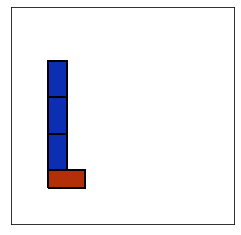

In [354]:
block_dims = [(2,1),(1,2)]
block_colors = ['#B32F0A','#0A2FB3']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

w = utils.World(block_dims = block_dims,
                block_colors = block_colors)

w.add_block(2,1,0,0)
w.snap_to_floor(1,2,0)
w.snap_to_floor(1,2,0)
w.snap_to_floor(1,2,0)
utils.draw_world(w)

In [355]:
w.tower_height()

7

In [349]:
w.get_block_dict()['blocks']

[{'x': 0, 'y': 0, 'height': 1, 'width': 2},
 {'x': 0, 'y': 1, 'height': 2, 'width': 1}]

### Enumerate upper bound of n-block towers

generate upper bound of stims by placing blocks in all x-positions, then adding a block to each of these in all positions

These define unique sequences of *block placements*, however many of the towers consist of the same blocks in the same place

In [256]:
# generate stims

max_blocks = 5

stims = {}

# single block in center of world
stims[1] = []

for block in block_dims:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.add_block(block[0], # width
                block[1], # height
                world_center,0)
    stims[1].append(w.get_block_dict()['blocks'])


# add a block in all available locations to all existing towers of n-1 blocks
for n_blocks in range(2,max_blocks+1):
    stims[n_blocks] = []

    # add block in position
    for stim_blocks in stims[n_blocks-1]:
        for block in block_dims:
            for x in range(0, world_width-1):
                #repopulate world
                w = utils.World(block_dims = block_dims,
                                block_colors = block_colors)
                w.populate_from_block_list(stim_blocks)

                #add new block
                w.snap_to_floor(block[0], # width
                            block[1], # height
                            x)
                stims[n_blocks].append(w.get_block_dict()['blocks'])


In [257]:
# how many of each? (not necessarily unique)
_ = [print(str(i) + ' block towers: ' + str(len(stims[i]))) for i in stims.keys()]

1 block towers: 2
2 block towers: 28
3 block towers: 392
4 block towers: 5488
5 block towers: 76832


### Equate towers of same blocks generated in different order

In [258]:
# convert dictionary representations of towers to (hashable) tuple and back
def world_dicts_to_tuples(wd):
    wt = tuple((block['x'],block['y'],block['height'],block['width']) for block in wd)
    return wt

def world_tuples_to_dicts(wt):
    wd = [{'x': block[0],
             'y': block[1],
             'height': block[2],
             'width': block[3]} for block in wt]
    return wd


# helper functions to reduce set of towers

def sort_blocks(stim_list):
    # sort the blocks within a tower to find unique towers
    sorted_list = [sorted(tower, key = lambda block: (block['x'],block['y'],block['height'],block['width'])) 
     for tower in stim_list]
    
    return sorted_list


def align_towers(stim_list):
    # place leftmost block in position 0
    # by subtracting min x ordinate from all x-values

    min_xs = [min([block['x'] for block in tower]) for tower in stim_list]

    aligned_towers = [[{'x': block['x'] - min_x,
       'y': block['y'],
       'height': block['height'],
       'width': block['width']}
      for block in tower] for (tower, min_x) in zip(stim_list, min_xs)]
    
    return aligned_towers

def convert_to_tuples(stim_list):
    return [world_dicts_to_tuples(tower) for tower in stim_list]

def find_unique_towers(stim_list):
    return set(stim_list)


#### sort blocks in tower

In [259]:
stims_sorted_blocks = {i : sort_blocks(stim_list) for _, (i, stim_list) in enumerate(stims.items())}

####  translational invariance- align all towers to left

In [260]:
stims_aligned_blocks = {i : align_towers(stim_list) for _, (i, stim_list) in enumerate(stims_sorted_blocks.items())}

####  find unique towers (i.e. same blocks in same place)

In [261]:
# convert to tuples for easy set operations
tower_tuples = {i : convert_to_tuples(stim_list) for _, (i, stim_list) in enumerate(stims_aligned_blocks.items())}

# now towers are sorted and aligned, find unique towers
unique_towers_tuples = {i : find_unique_towers(stim_list) for _, (i, stim_list) in enumerate(tower_tuples.items())}

# convert back to dictionary for easier tower-operations
unique_towers_dicts = {i : [world_tuples_to_dicts(tower) for tower in stim_list]
                           for _, (i, stim_list) in enumerate(unique_towers_tuples.items())}

In [262]:
print('Unique block towers (same blocks in same place):')
_ = [print(str(i) + ' block: ' + str(len(unique_towers_dicts[i]))) for i in unique_towers_dicts.keys()]

Unique block towers (same blocks in same place):
1 block: 2
2 block: 18
3 block: 162
4 block: 1234
5 block: 8384


### Create dataframe with properties of towers

In [263]:
df_stim = pd.DataFrame()

for _, (i, stim_list) in enumerate(unique_towers_dicts.items()):
    for stim in stim_list:
        world = utils.worldify(stim) # convert to world object
        
        df_stim = df_stim.append(
        {
            'stim': stim,
            'stim_tuple': world_dicts_to_tuples(stim),
            'n_blocks': i,
            'fully_connected': world.fully_connected(connectivity=1),
            'fully_connected_diag': world.fully_connected(connectivity=2),
            'blocks_above_ground': world.n_blocks_above_ground(),
            'two_h_two_v': world.two_h_two_v(),
            'silhouette': world.block_map
        }, ignore_index=True).astype(object)
        
df_stim['fully_connected'] = df_stim['fully_connected'].astype(np.bool)
df_stim['fully_connected_diag'] = df_stim['fully_connected_diag'].astype(np.bool)
df_stim['two_h_two_v'] = df_stim['two_h_two_v'].astype(np.bool)

df_stim['silhouette_str'] = df_stim['silhouette'].apply(utils.convert_to_str)

In [264]:
df_stim_full = df_stim

In [265]:
df_stim_full = df_stim_full.sort_values('silhouette_str').reset_index()

In [266]:
#df_stim = df_stim[df_stim.n_blocks<=4]

####  find unique towers (same silhouette)

In [267]:
df_stim_silhouettes = df_stim.groupby(['n_blocks','silhouette_str']).agg('first').reset_index()

### Visualize effect of params on number of stims

In [268]:
silhouette_counts = {
    'all': len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4)]),
    '+fully_connected':len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected)]),
    '+2h_2v':len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected) & 
            (df_stim_silhouettes.two_h_two_v)]),
    '+1_above_ground' : len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected) & 
            (df_stim_silhouettes.two_h_two_v) &
            (df_stim_silhouettes.blocks_above_ground>=1)]),
    '+2_above_ground' : len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected) & 
            (df_stim_silhouettes.two_h_two_v) &
            (df_stim_silhouettes.blocks_above_ground>=2)])
}
silhouette_counts

{'all': 1061,
 '+fully_connected': 405,
 '+2h_2v': 148,
 '+1_above_ground': 144,
 '+2_above_ground': 115}

In [269]:
full_counts = {
    'all': len(df_stim_full[(df_stim_full.n_blocks==4)]),
    '+fully_connected':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected)]),
    '+2h_2v':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected) & 
            (df_stim_full.two_h_two_v)]),
    '+1_above_ground':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected) & 
            (df_stim_full.two_h_two_v) &
            (df_stim_full.blocks_above_ground>=1)]),
    '+2_above_ground':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected) & 
            (df_stim_full.two_h_two_v) &
            (df_stim_full.blocks_above_ground>=2)])
}
full_counts

{'all': 1234,
 '+fully_connected': 491,
 '+2h_2v': 173,
 '+1_above_ground': 167,
 '+2_above_ground': 133}

In [270]:
silhouette_counts = {
    'all': len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4)]),
    '+fully_connected':len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected)]),
    '+1_above_ground' : len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected) & 
            (df_stim_silhouettes.blocks_above_ground>=1)]),
    '+2_above_ground' : len(df_stim_silhouettes[(df_stim_silhouettes.n_blocks==4) &
            (df_stim_silhouettes.fully_connected) & 
            (df_stim_silhouettes.blocks_above_ground>=2)])
}
silhouette_counts

{'all': 1061,
 '+fully_connected': 405,
 '+1_above_ground': 396,
 '+2_above_ground': 326}

In [271]:
full_counts = {
    'all': len(df_stim_full[(df_stim_full.n_blocks==4)]),
    '+fully_connected':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected)]),
    '+1_above_ground':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected) & 
            (df_stim_full.blocks_above_ground>=1)]),
    '+2_above_ground':len(df_stim_full[(df_stim_full.n_blocks==4) &
            (df_stim_full.fully_connected) & 
            (df_stim_full.blocks_above_ground>=2)])
}
full_counts

{'all': 1234,
 '+fully_connected': 491,
 '+1_above_ground': 477,
 '+2_above_ground': 389}

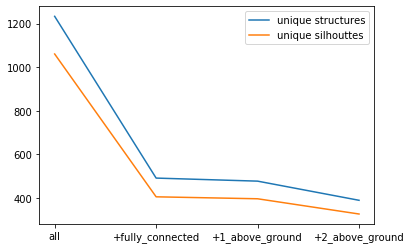

In [272]:
sns.lineplot(x=list(full_counts.keys()), y=list(full_counts.values()) ,sort=False)
sns.lineplot(x=list(silhouette_counts.keys()), y=list(silhouette_counts.values()), sort=False)
plt.legend(['unique structures','unique silhouttes'])

#### plot

uniqueness

fully_connected
blocks_above_ground > 1
two_h_two_v


#### subtowers

marginal (just label the chunk) vs. conditional (label the chunk conditional on certain blocks already being there)


spatial contiguity within chunk
consecutive commands


1. Which subtowers?
- spatially contiguous
   - yes: prunes annotations, show no consistent names for weird chunks
   - no: biases annotations
- can be produced consecutive commands
- more than one block?
    - because they'll likely always be called 'horizontal/ blue'
- 

Less exhaustive with towers, but exhaustive with subtowers


2. How do we present each subtower?
- presented in isolation
    - 'what do you call this chunk?' (may or may not be correct for CA task)
- presented with entire tower context
    - 'what do you call the part of this tower?'
    - can collapse across chunks in different places
- presented with subtower context


1. How does a speaker chunk a tower? (perceptual priors)
2. What priors do people have for labelling these chunks? (linguistic priors conditioned on percepts)
3. Perceptual learning throughout task
4. Conventional learning


todo:
- draft instructions. What are we saying to annotators?
- Think about subtower space: confirm that it's a 10x multiplier
- Think about subtower context
- plots


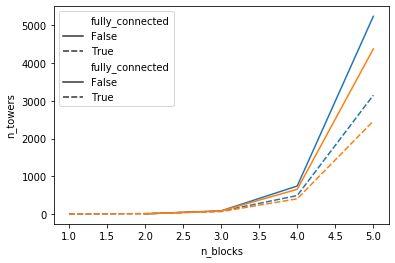

In [273]:
# unique by blocks
fully_connected_counts = df_stim.groupby(['n_blocks','fully_connected']).agg('count').reset_index()
sns.lineplot(x='n_blocks', y='stim', style='fully_connected', data=fully_connected_counts)

# unique by silhouette
fully_connected_counts = df_stim_silhouettes.groupby(['n_blocks','fully_connected']).agg('count').reset_index()
sns.lineplot(x='n_blocks', y='stim', style='fully_connected', data=fully_connected_counts)

_ = plt.ylabel('n_towers')

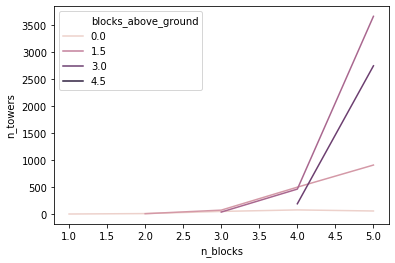

In [274]:
# unique by blocks
blocks_above_ground_counts = df_stim.groupby(['n_blocks','blocks_above_ground']).agg('count').reset_index()
sns.lineplot(x='n_blocks', y='stim', hue='blocks_above_ground', data=blocks_above_ground_counts)

# unique by silhouettes
# blocks_above_ground_counts = df_stim_silhouettes.groupby(['n_blocks','blocks_above_ground']).agg('count').reset_index()
# sns.lineplot(x='n_blocks', y='stim', hue='blocks_above_ground', data=blocks_above_ground_counts)

_ = plt.ylabel('n_towers')


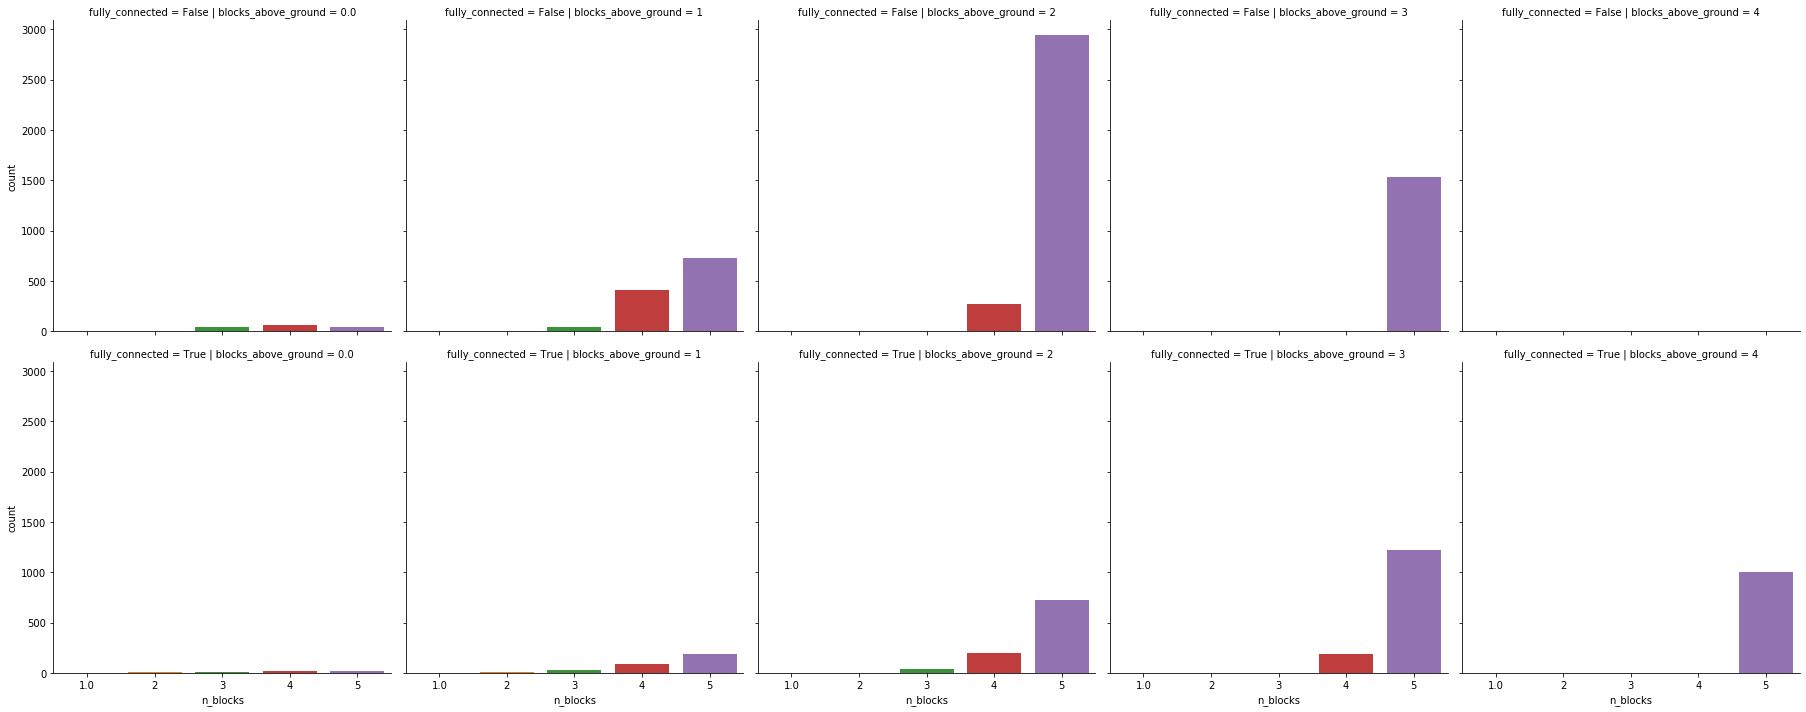

In [275]:
g = sns.catplot(data = df_stim, x='n_blocks', row='fully_connected', col='blocks_above_ground', kind="count")

### Apply filters to towers

- connected
- at least 1 or 2 blocks off ground
- 2 horizontal, 2 vertical
- height
- max width




#### unique by blocks used

In [276]:
reduced = df_stim_full[(df_stim_full.n_blocks==4) &
                (df_stim_full.fully_connected) & 
                (df_stim_full.two_h_two_v) &
                (df_stim_full.blocks_above_ground>=2)]

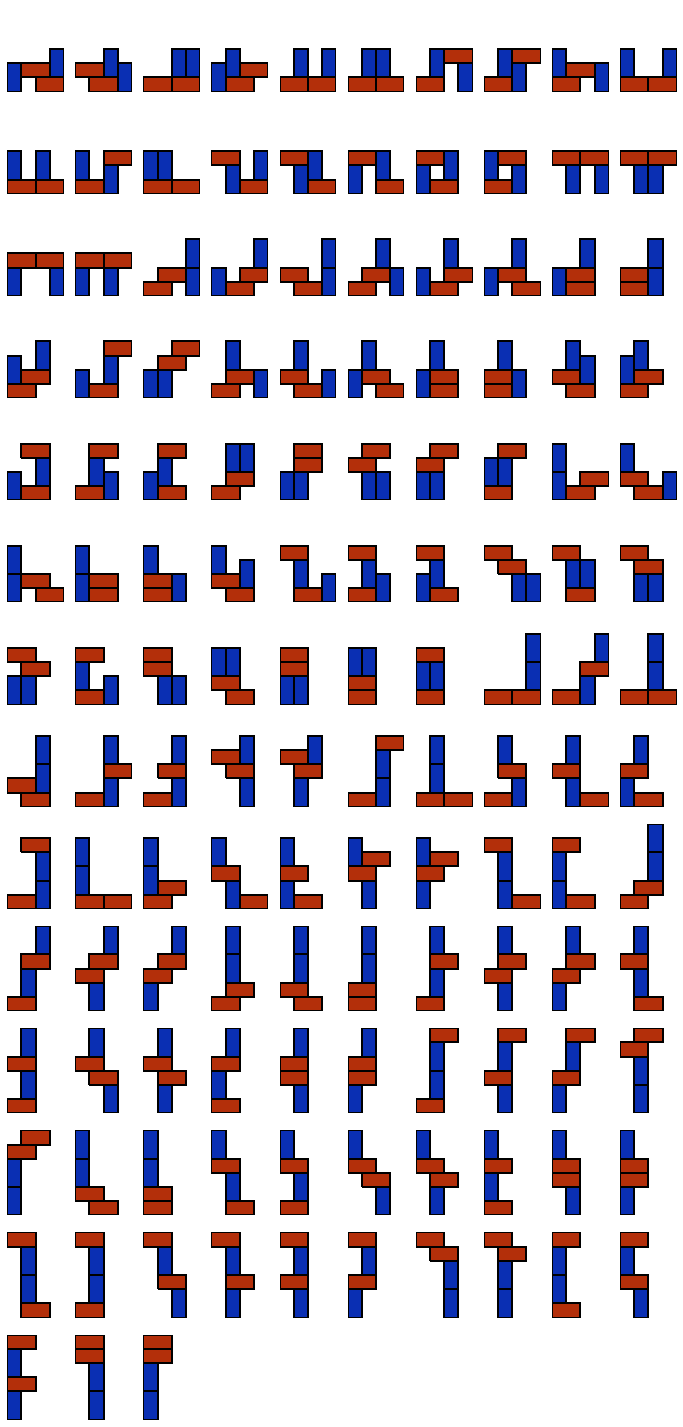

In [280]:
utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
                                  block_colors = block_colors) 
                   for w in reduced['stim']],
                 figsize=(12,26))

In [278]:
len(reduced)

133

#### unique by silhouette

In [226]:
black = ['#000000','#000000']

In [281]:
unique_silhouettes_reduced = reduced.groupby('silhouette_str').agg('first').reset_index()

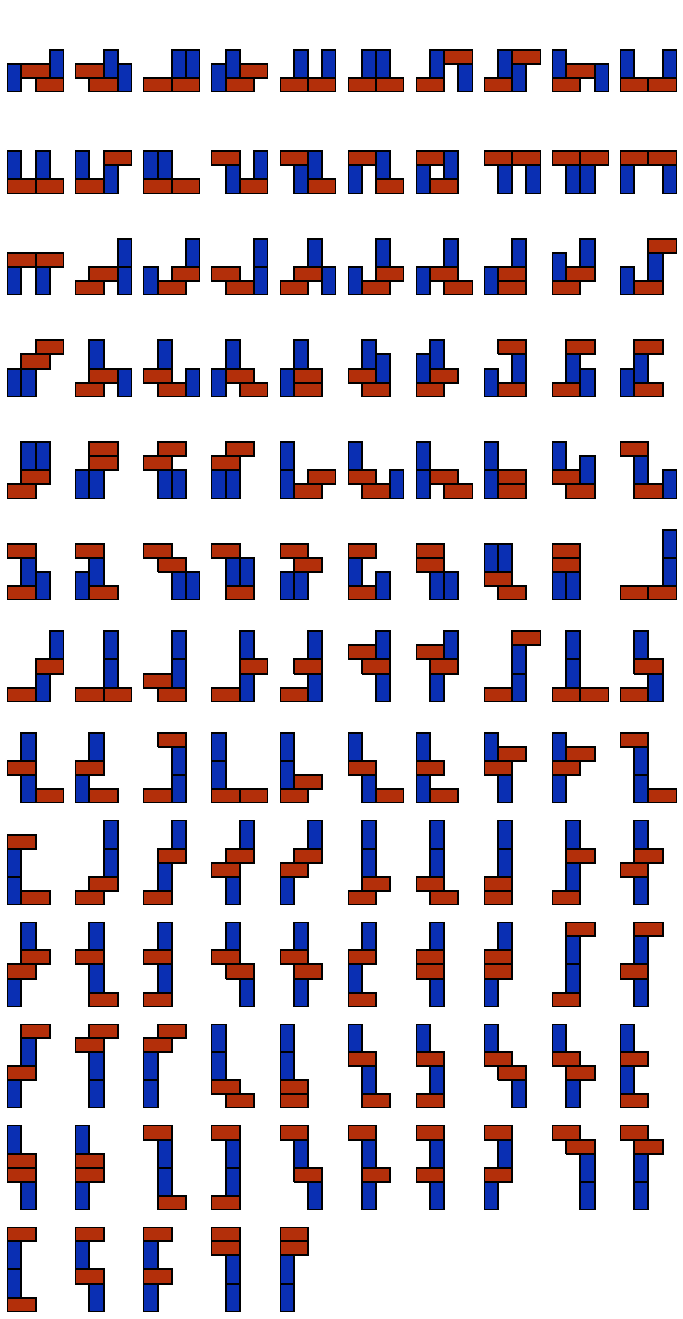

In [282]:
utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in unique_silhouettes_reduced['stim']],
                 figsize=(12,24))

In [283]:
len(unique_silhouettes_reduced)

125

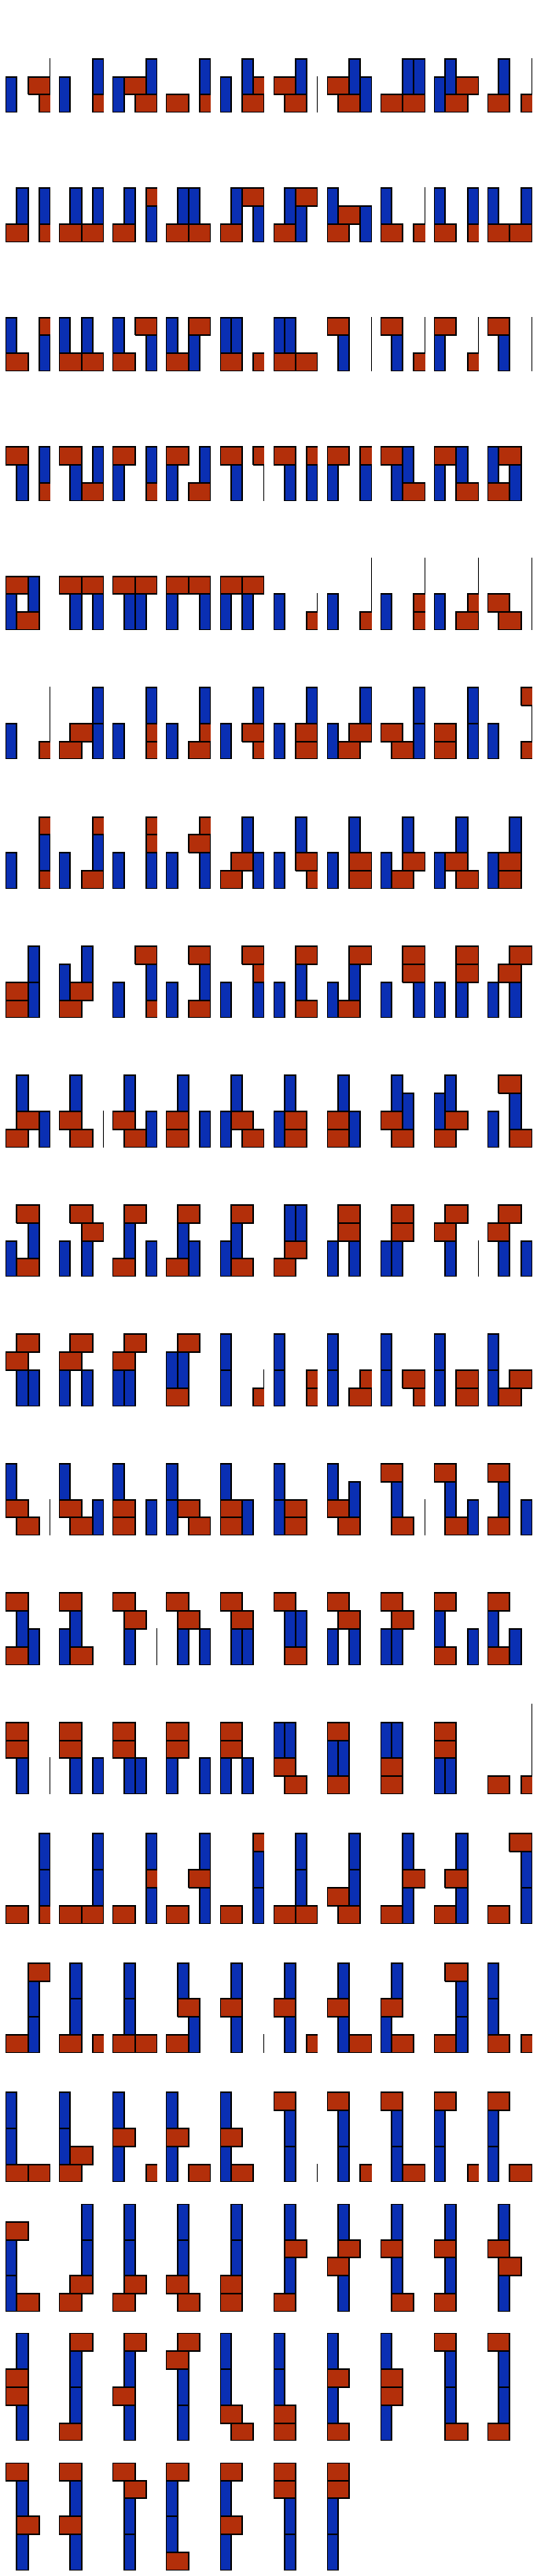

In [234]:
#Extensive search

big_set = df_stim_full[(df_stim_full.n_blocks==4) &
                       (df_stim_full.two_h_two_v) &
                       (df_stim_full.blocks_above_ground>=2)]


utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in big_set['stim']],
                 figsize=(12,60))

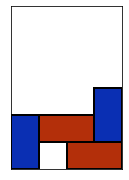

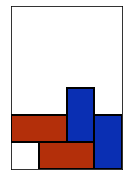

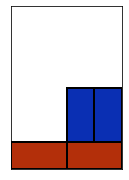

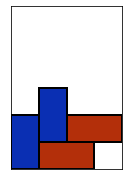

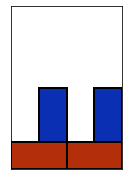

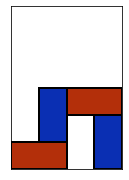

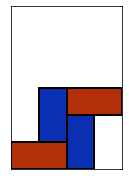

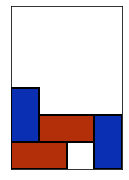

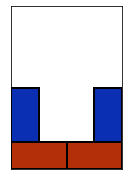

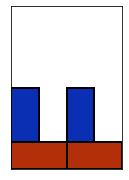

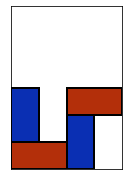

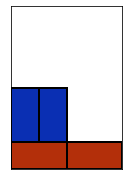

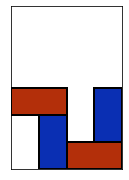

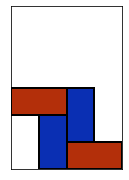

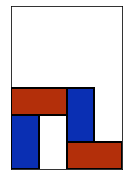

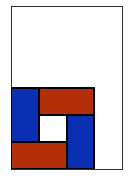

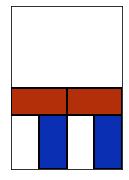

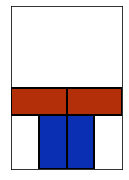

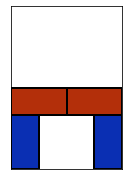

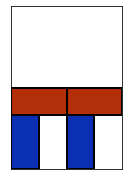

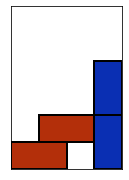

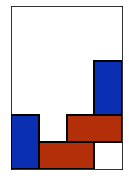

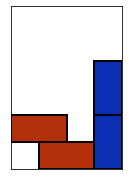

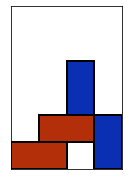

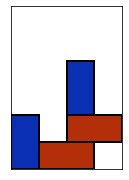

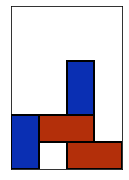

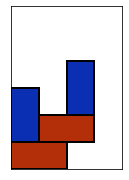

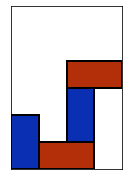

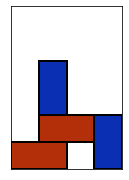

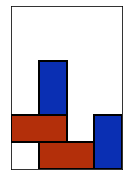

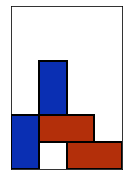

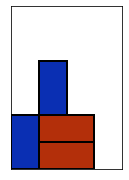

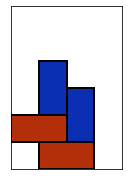

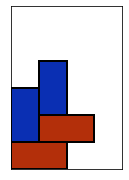

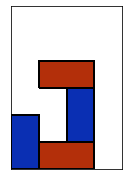

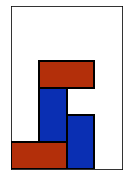

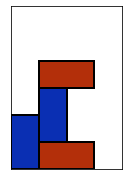

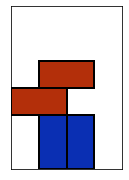

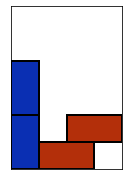

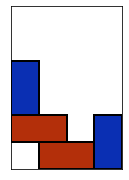

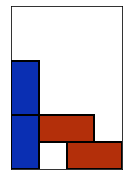

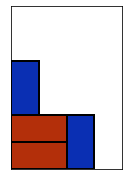

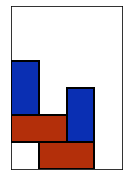

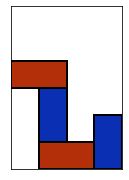

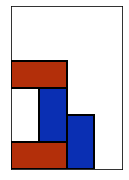

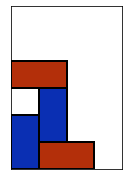

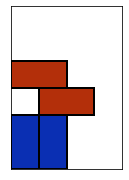

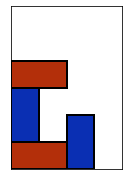

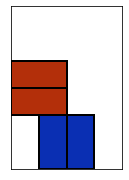

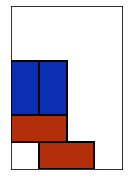

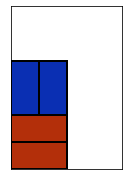

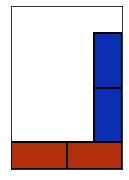

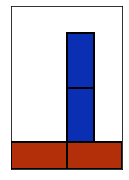

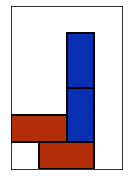

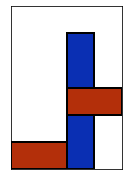

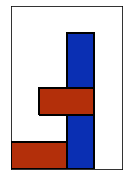

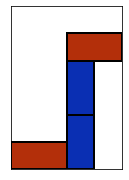

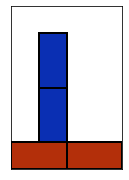

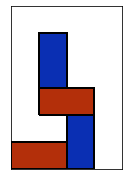

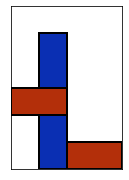

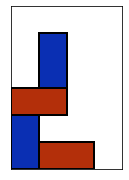

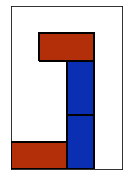

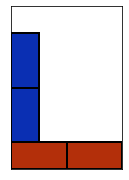

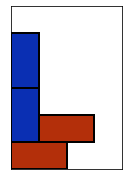

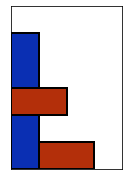

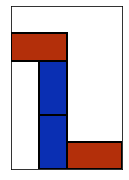

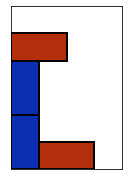

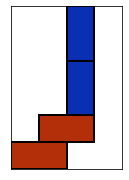

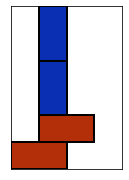

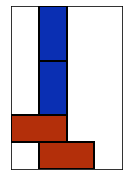

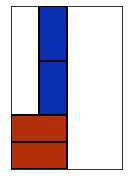

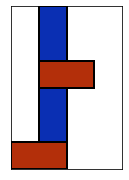

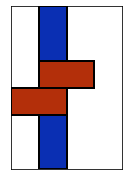

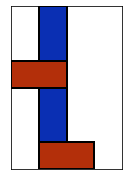

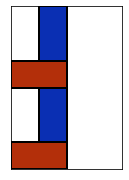

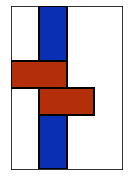

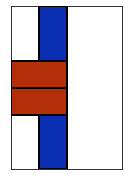

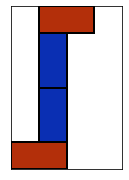

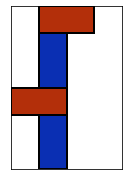

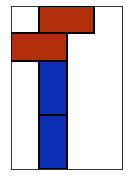

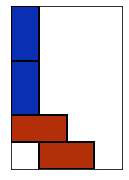

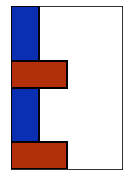

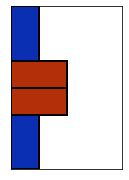

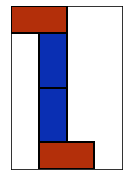

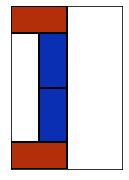

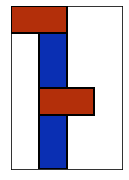

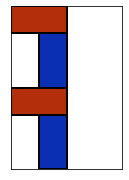

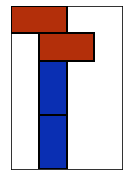

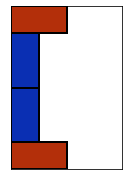

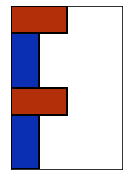

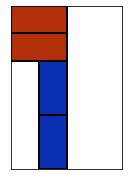

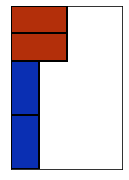

In [93]:
for blocks in current_stim_set['stim']:
    w = utils.World(block_dims = block_dims,
                    block_colors = block_colors, 
                    world_height= 5,
                    world_width= 5)
    w.populate_from_block_list(blocks)
#     print(w.fully_connected())
    utils.draw_tower(w)

In [80]:
ambiguous_silhouettes = reduced_set.groupby('silhouette_str').agg('first')[reduced_set.groupby('silhouette_str').agg('count')['blocks_above_ground'] > 1]['stim']

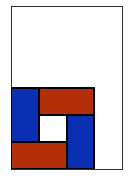

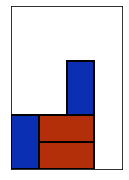

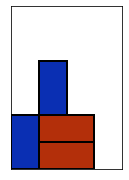

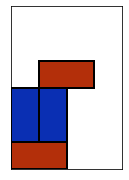

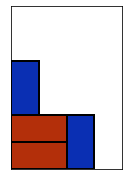

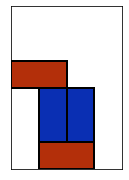

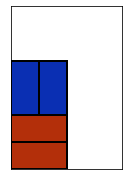

In [94]:
for blocks in ambiguous_silhouettes:
    w = utils.World(block_dims = block_dims,
                    block_colors = block_colors)
    w.populate_from_block_list(blocks)
#     print(w.fully_connected())
    utils.draw_tower(w)

In [69]:
len(current_stim_set.groupby('silhouette_str').agg('first'))

92

In [133]:
importlib.reload(utils)

<module 'blockworld_helpers' from '/Users/will/compositional-abstractions/stimuli/blockworld_helpers.py'>

In [145]:
! git push

Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 8 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 54.64 KiB | 3.64 MiB/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
remote: This repository moved. Please use the new location:
remote:   https://github.com/cogtoolslab/compositional-abstractions.git
To https://github.com/hawkrobe/compositional-abstractions.git
   9d5bcf2..3f30bc8  master -> master
